# Read in Data

In [2]:
import pandas as pd
import numpy as np
from typing import Optional

In [3]:
from custom_datasets import MultiLangDataset, SplitSet
from custom_datasets import ns_dataset
from custom_datasets import Languages
from custom_datasets import clean_tweet
from constants import TokenizerEnum, VectorizerEnum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from custom_vectorizers import get_vectorizer

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout,Input, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

In [5]:
YOR_DATASET: SplitSet = ns_dataset.get(Languages.YORUBA)
HAU_DATASET: SplitSet = ns_dataset.get(Languages.HAUSA)
IBO_DATASET: SplitSet = ns_dataset.get(Languages.IGBO)
PCM_DATASET: SplitSet = ns_dataset.get(Languages.NIGERIAN_PIDGIN)

In [6]:
# Evaluator
from analysis import compare_results

# Tokenizer
from subword_tokenizer import (
    get_tokenizer,
    wordpiece_tokenize_dataframe,
    get_sentencepiece_tokenizer,
    sentencepiece_tokenize_dataframe,
    get_wordpiece_tokeized_data,
    get_sentencepiece_tokeized_data
)

# Compare Results
from sklearn.metrics import accuracy_score, classification_report

In [7]:
def encode_labels(df: pd.DataFrame):
    label_mapping = {"positive": 0, "neutral": 1, "negative": 2}
    df["label_encoded"] = df["label"].str.lower().map(label_mapping)

In [8]:
# VECTORIZER_KWARGS = {
#     "ngram": (1, 2),
#     "max_features": 3700,}

VECTORIZER_KWARGS = {}

# Naive Bayes

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


def naive_bayes(
    dataset: SplitSet, vectorizer: VectorizerEnum,  tokenizer: Optional[TokenizerEnum] = None
) -> dict:
    """
    Naive Bayes classifier for text classification.
    Args:
        dataset (SplitSet): The dataset to use for training and testing.
        tokenizer (TokenizerEnum): The tokenizer to use.
        If tokenizer is None, then no tokenization is applied. Only vectorization is applied.
        vectorizer (VectorizerEnum): The vectorizer to use.
    Returns:
        dict: A dictionary containing the results of the classification.
        Returns a classification report
    """
    
    X_train, y_train = dataset.train["tweet"], dataset.train["label"]
    X_test, y_test = dataset.test["tweet"], dataset.test["label"]

    if tokenizer is TokenizerEnum.SENTENCEPIECE:
        print("Using SentencePiece tokenizer")
        sp_tokenizer = get_sentencepiece_tokenizer(
            df=dataset.train,
        )

        def sentencepiece_tokenizer(text):
            return sp_tokenizer.encode(text, out_type=str)

        vectorizer = (
            CountVectorizer(tokenizer=sentencepiece_tokenizer)
            if vectorizer == VectorizerEnum.BOW
            else TfidfVectorizer(tokenizer=sentencepiece_tokenizer)
        )
    elif tokenizer is TokenizerEnum.WORDPIECE:
        print("Using WordPiece tokenizer")
        wp_tokenizer = get_tokenizer(
            df=dataset.train,
        )

        def wordpiece_tokenizer(text):
            return wp_tokenizer.encode(text).tokens

        vectorizer = (
            CountVectorizer(tokenizer=wordpiece_tokenizer)
            if vectorizer == VectorizerEnum.BOW
            else TfidfVectorizer(tokenizer=wordpiece_tokenizer)
        )
    elif tokenizer is None:
        vectorizer = (
            CountVectorizer(stop_words=dataset.stopwords)
            if vectorizer == VectorizerEnum.BOW
            else TfidfVectorizer(stop_words=dataset.stopwords)
        )

    model = Pipeline(
        [
            ("vectorizer", vectorizer),
            ("classifier", MultinomialNB()),
        ]
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    word_result: dict = classification_report(y_test, y_pred, output_dict=True)
    return word_result

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression


def logistic_regression(
    dataset: SplitSet, vectorizer: VectorizerEnum,  tokenizer: Optional[TokenizerEnum] = None
) -> dict:
    """
    Logistic Regression classifier for text classification.
    Args:
        dataset (SplitSet): The dataset to use for training and testing.
        tokenizer (TokenizerEnum): The tokenizer to use.
        If tokenizer is None, then no tokenization is applied. Only vectorization is applied.
        vectorizer (VectorizerEnum): The vectorizer to use.
    Returns:
        dict: A dictionary containing the results of the classification.
        Returns a classification report
    """
    X_train, y_train = dataset.train["tweet"], dataset.train["label"]
    X_test, y_test = dataset.test["tweet"], dataset.test["label"]

    if tokenizer is TokenizerEnum.SENTENCEPIECE:
        print("Using SentencePiece tokenizer")
        sp_tokenizer = get_sentencepiece_tokenizer(
            df=dataset.train,
        )

        def sentencepiece_tokenizer(text):
            return sp_tokenizer.encode(text, out_type=str)

        vectorizer = (
            CountVectorizer(tokenizer=sentencepiece_tokenizer)
            if vectorizer == VectorizerEnum.BOW
            else TfidfVectorizer(tokenizer=sentencepiece_tokenizer)
        )
    elif tokenizer is TokenizerEnum.WORDPIECE:
        print("Using WordPiece tokenizer")
        wp_tokenizer = get_tokenizer(
            df=dataset.train,
        )

        def wordpiece_tokenizer(text):
            return wp_tokenizer.encode(text).tokens

        vectorizer = (
            CountVectorizer(tokenizer=wordpiece_tokenizer)
            if vectorizer == VectorizerEnum.BOW
            else TfidfVectorizer(tokenizer=wordpiece_tokenizer)
        )
    elif tokenizer is None:
        vectorizer = (
            CountVectorizer(stop_words=dataset.stopwords)
            if vectorizer == VectorizerEnum.BOW
            else TfidfVectorizer(stop_words=dataset.stopwords)
        )

    model = Pipeline(
        [
            ("vectorizer", vectorizer),
            ("classifier", LogisticRegression(max_iter=2000)),
        ]
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    word_result: dict = classification_report(y_test, y_pred, output_dict=True)
    return word_result

# Neural Network

In [ ]:



def neural_network(
    dataset: SplitSet, vectorizer: VectorizerEnum,  tokenizer: Optional[TokenizerEnum] = None, clean_tweets: bool = True
) -> dict:
    """
    Neural Network classifier for text classification.
    Args:
        dataset (SplitSet): The dataset to use for training and testing.
        tokenizer (TokenizerEnum): The tokenizer to use.
        If tokenizer is None, then no tokenization is applied. Only vectorization is applied.
        vectorizer (VectorizerEnum): The vectorizer to use.
    Returns:
        dict: A dictionary containing the results of the classification.
        Returns a classification report
    """
    pass

    df = dataset.train
    # encode_labels(df)
    if clean_tweets:
        df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)
    encode_labels(df)

    if tokenizer is not None:
        neural_input = get_wordpiece_tokeized_data(
            df,
            vocab_size=3700,
            tweet_column="cleaned_tweet",
            vectorizer_kwargs={"ngram": (1, 2), "max_features": None},
        )
    elif tokenizer == TokenizerEnum.SENTENCEPIECE:
        neural_input = get_sentencepiece_tokeized_data(
            df,
            vocab_size=3700,
            tweet_column="cleaned_tweet",
            vectorizer_kwargs={"ngram": (1, 2), "max_features": None},
        )

    model = Sequential()
    model.add(Input(shape=(neural_input.X_train.shape[1],)))

    # Dense layers for TF-IDF input
    # (512, 256, 128)
    # (8, 4, 2)
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dense(3, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(),
        metrics=["accuracy"],
    )

    X = np.array(neural_input.get_dense_X_train())
    y = np.array(neural_input.y_train)

    model.fit(X, y, epochs=10, batch_size=64, verbose=1)

    # Evaluate the model
    # model.evaluate(neural_input.X_test, neural_input.y_test)
    y_pred = model.predict(
        np.array(neural_input.get_dense_X_test()),
    )
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(neural_input.y_test, y_pred_classes)
    print(f"Accuracy with filtered tweets {accuracy:.4f}")

    
    return classification_report(
            neural_input.y_test,
            y_pred_classes,
            target_names=["positive", "neutral", "negative"],
            output_dict=True
        )
    

In [ ]:
nn_yor_kwargs ={
    "nn_yor_wp_clean":{
        "dataset": YOR_DATASET,
        "vectorizer": VectorizerEnum.TFIDF,
        "tokenizer": TokenizerEnum.WORDPIECE,
        "clean_tweets": True
    },
    "nn_yor_wp_no_clean":{
        "dataset": YOR_DATASET,
        "vectorizer": VectorizerEnum.TFIDF,
        "tokenizer": TokenizerEnum.WORDPIECE,
        "clean_tweets": False
    },
    "nn_yor_sp_clean" : {
        "dataset": YOR_DATASET,
        "vectorizer": VectorizerEnum.TFIDF,
        "tokenizer": TokenizerEnum.SENTENCEPIECE,
        "clean_tweets": True
    },
    "nn_yor_sp_no_clean" : {
        "dataset": YOR_DATASET,
        "vectorizer": VectorizerEnum.TFIDF,
        "tokenizer": TokenizerEnum.SENTENCEPIECE,
        "clean_tweets": False
    }
}

nn_yor_wp = neural_network(**nn_yor_kwargs["nn_yor_wp_clean"])
nn_yor_wp_no_clean = neural_network(**nn_yor_kwargs["nn_yor_wp_no_clean"])
nn_yor_sp = neural_network(**nn_yor_kwargs["nn_yor_sp_clean"])
nn_yor_sp_no_clean = neural_network(**nn_yor_kwargs["nn_yor_sp_no_clean"])


compare_results(
    normal_result=nn_yor_wp,
    subword_result=nn_yor_sp,
)

compare_results(
    normal_result=nn_yor_sp,
    subword_result=nn_yor_wp,
)

compare_results(
    normal_result=nn_yor_wp_no_clean,
    subword_result=nn_yor_sp_no_clean,
)

In [ ]:
result1 = neural_network(
    dataset=YOR_DATASET,
    vectorizer=VectorizerEnum.TFIDF,
    tokenizer=TokenizerEnum.WORDPIECE,
)
result2 = neural_network(
    dataset=YOR_DATASET,
    vectorizer=VectorizerEnum.TFIDF,
    tokenizer=TokenizerEnum.WORDPIECE,
    clean_tweets=False
)

compare_results(normal_result=result1, subword_result=result2)

c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fẹ', 'jẹ', 'rẹ', 'rọ', 'wọ'] not in stop_words.
  warnings.warn(


Using WordPiece tokenizer


c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Normal Tokenization Results:
              precision  recall  f1-score   support
negative          0.640   0.530     0.580   981.000
neutral           0.728   0.679     0.703  1616.000
positive          0.730   0.836     0.779  1918.000
accuracy          0.713   0.713     0.713     0.713
macro avg         0.699   0.682     0.687  4515.000
weighted avg      0.710   0.713     0.709  4515.000
--------------------------------------------------
Subword Tokenization Results:
              precision  recall  f1-score   support
negative          0.573   0.669     0.617   981.000
neutral           0.738   0.640     0.685  1616.000
positive          0.778   0.799     0.789  1918.000
accuracy          0.714   0.714     0.714     0.714
macro avg         0.697   0.703     0.697  4515.000
weighted avg      0.719   0.714     0.714  4515.000
--------------------------------------------------

📊 Class-Level Breakdown with Deltas:
      class  normal_precision  subword_precision  diff_precision  \
0  ne

c:\Users\jesse\Dev\cos760-nlp-project\analysis.py:66: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


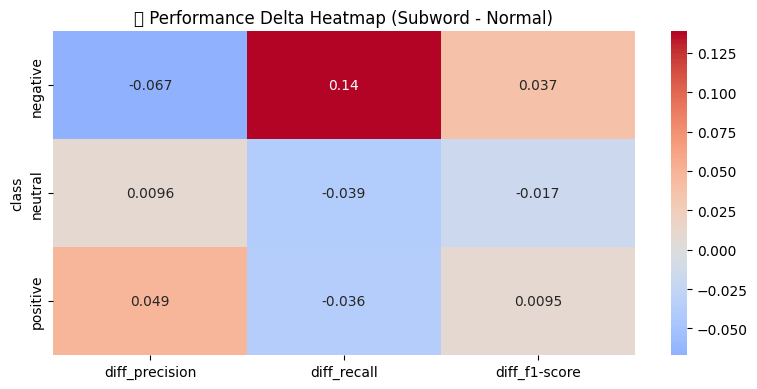


✅ Overall Summary:
               Normal   Subword      Diff
Accuracy     0.713178  0.713843  0.000664
Macro F1     0.687296  0.697147  0.009851
Weighted F1  0.708523  0.714477  0.005954

🧠 Final Conclusion:
→ Subword tokenization achieves better overall accuracy.
→ Class-wise, Subword tokenization improves recall for 'negative' but underperforms on 'neutral' and 'positive' in both recall and F1.
→ Overall, normal tokenization provides more balanced and accurate classification.

Analysis complete.

--------------------------------------------------
--------------------------------------------------



In [12]:
result1 = logistic_regression(dataset=YOR_DATASET, vectorizer=VectorizerEnum.TFIDF)
result2 = logistic_regression(
    dataset=YOR_DATASET,
    vectorizer=VectorizerEnum.TFIDF,
    tokenizer=TokenizerEnum.WORDPIECE,
)

compare_results(normal_result=result1, subword_result=result2)

c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fẹ', 'jẹ', 'rẹ', 'rọ', 'wọ'] not in stop_words.
  warnings.warn(


Using WordPiece tokenizer


c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Normal Tokenization Results:
              precision  recall  f1-score   support
negative          0.852   0.111     0.197   981.000
neutral           0.667   0.703     0.684  1616.000
positive          0.628   0.879     0.732  1918.000
accuracy          0.649   0.649     0.649     0.649
macro avg         0.715   0.564     0.538  4515.000
weighted avg      0.690   0.649     0.599  4515.000
--------------------------------------------------
Subword Tokenization Results:
              precision  recall  f1-score   support
negative          0.826   0.276     0.414   981.000
neutral           0.699   0.700     0.699  1616.000
positive          0.666   0.892     0.763  1918.000
accuracy          0.689   0.689     0.689     0.689
macro avg         0.730   0.623     0.625  4515.000
weighted avg      0.713   0.689     0.664  4515.000
--------------------------------------------------

📊 Class-Level Breakdown with Deltas:
      class  normal_precision  subword_precision  diff_precision  \
0  ne

c:\Users\jesse\Dev\cos760-nlp-project\analysis.py:66: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


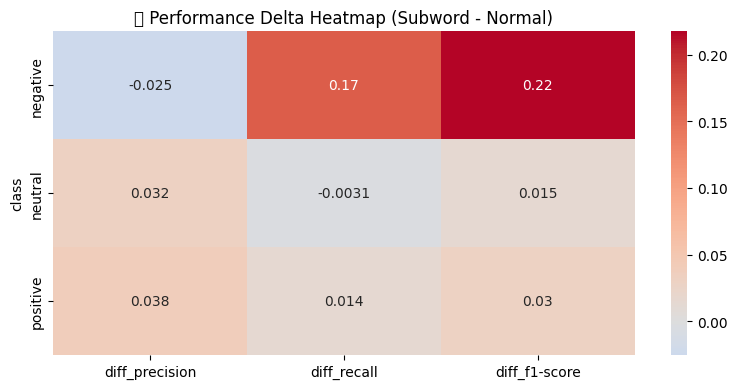


✅ Overall Summary:
               Normal   Subword      Diff
Accuracy     0.648948  0.689480  0.040532
Macro F1     0.537787  0.625383  0.087596
Weighted F1  0.598796  0.664285  0.065489

🧠 Final Conclusion:
→ Subword tokenization achieves better overall accuracy.
→ Class-wise, Subword tokenization improves recall for 'negative' but underperforms on 'neutral' and 'positive' in both recall and F1.
→ Overall, normal tokenization provides more balanced and accurate classification.

Analysis complete.

--------------------------------------------------
--------------------------------------------------



In [10]:
result1 = naive_bayes(dataset=YOR_DATASET, vectorizer=VectorizerEnum.TFIDF)
result2 = naive_bayes(
    dataset=YOR_DATASET,
    vectorizer=VectorizerEnum.TFIDF,
    tokenizer=TokenizerEnum.WORDPIECE,
)

compare_results(normal_result=result1, subword_result=result2)